# First Test: Median filter with real data.

## DW (2015.11.23)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, triang
import sys
# Add a new path with needed .py files.
sys.path.insert(0, 'C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\MedianFilter\Python') 

import functions
import gitInformation
import nlxio

In [3]:
%matplotlib inline

In [4]:
gitInformation.printInformation()

Information about this notebook
Date: 2015-11-25
Python Version: 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, Nov  7 2015, 13:18:40) [MSC v.1500 64 bit (AMD64)]
Git directory: C:\Users\Dominik\Documents\GitRep\kt-2015-DSPHandsOn\.git
Current git SHA: 7a6182a51780ca63d03858bf99500e03ff195046
Remotes: fork, origin, 
Current branch: master
fork remote URL: http://github.com/dowa4213/kt-2015-DSPHandsOn.git
origin remote URL: https://github.com/ktakagaki/kt-2015-DSPHandsOn.git


### Figure 1. Real Data

In [5]:
# Load some .ncs(neuralynx continuous sample file) data with nlxio
# nlxio taken from https://github.com/bwillers/nlxio
csc = nlxio.loadNcs('CSC2_2906536002_2913013352.ncs', should_read_time = False)
csc2 = nlxio.loadNcs('CSC2_7058725145_7166174892.ncs', should_read_time = False)

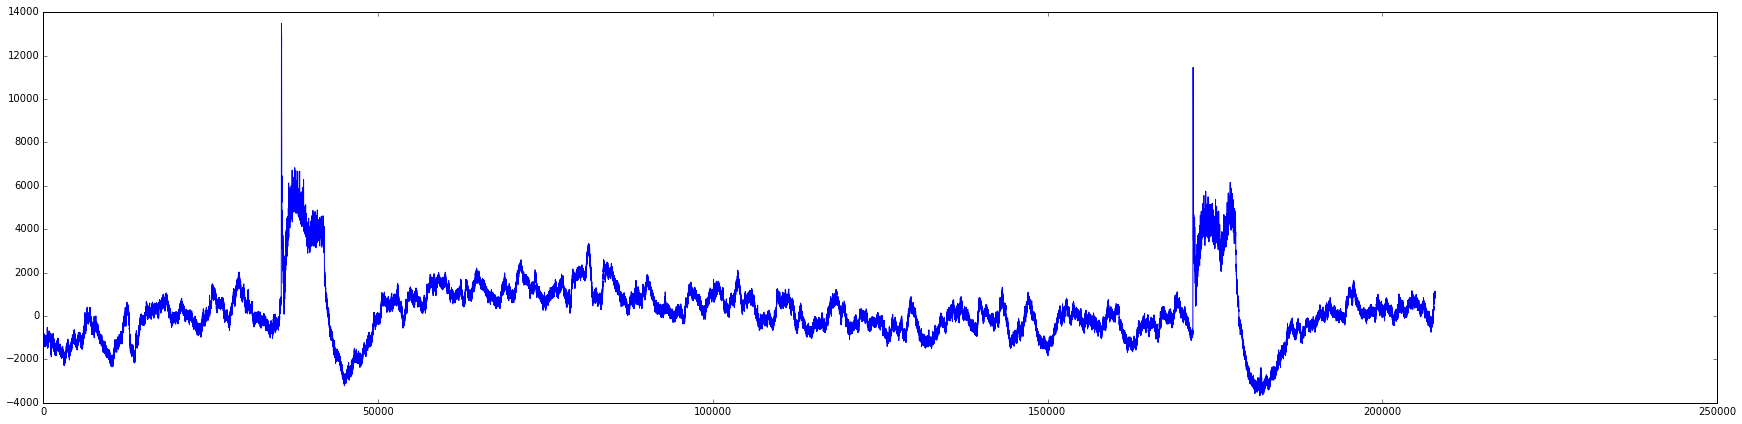

In [6]:
plt.figure(figsize=(30,7))
plt.plot(csc)

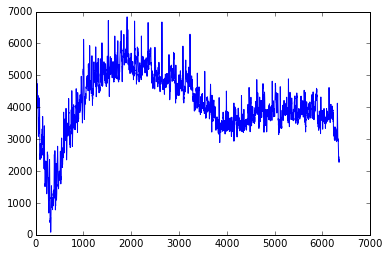

In [9]:
plt.plot(csc[35650:42000])

In [48]:
# Testing the median filter with some different window lengths.
wl = [71, 81, 91, 101, 111]

In [49]:
filtered = np.zeros((len(csc), len(wl)))

In [50]:
count = -1
for w in wl:
    count = count + 1
    # Median filter the csc data.
    filtered[:,count] = medfilt(csc, w)
np.savetxt("filtereddata.txt", filtered)

In [51]:
filtered = np.loadtxt('filtereddata.txt')

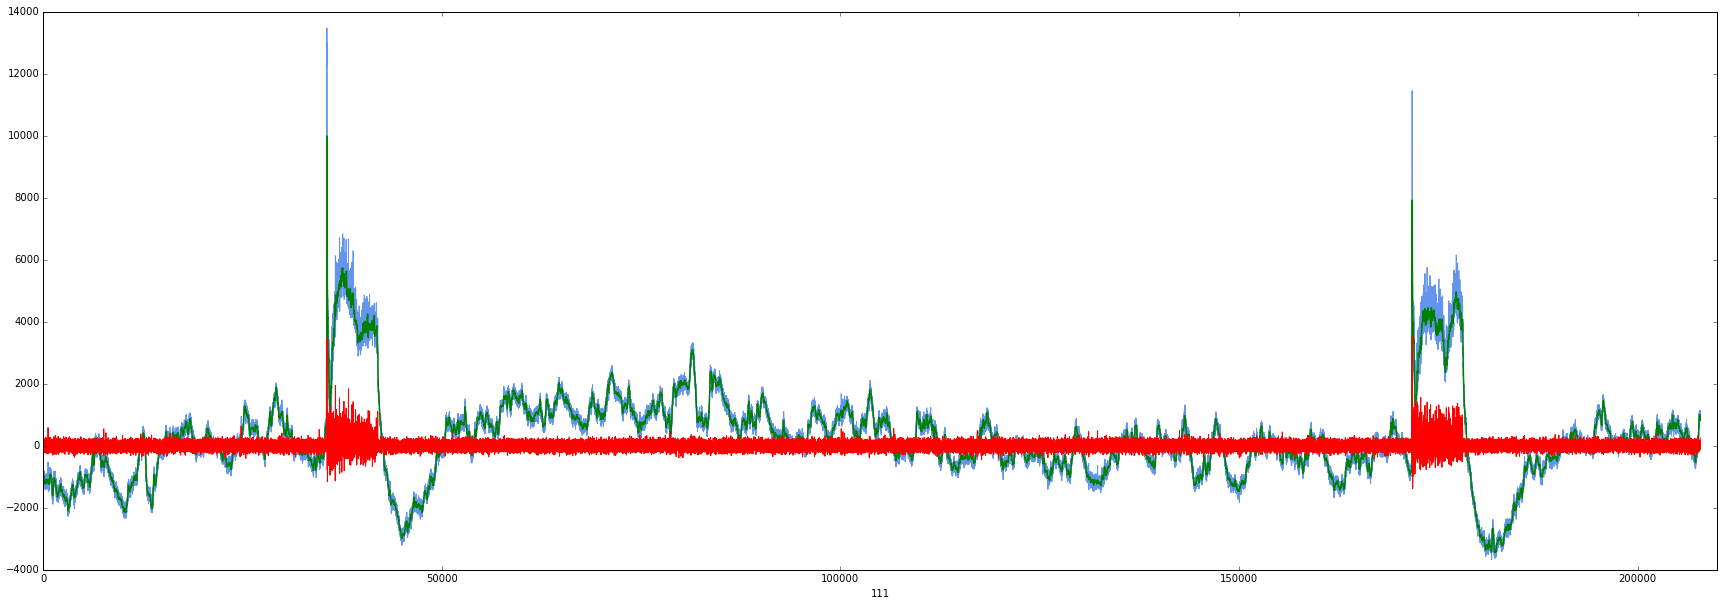

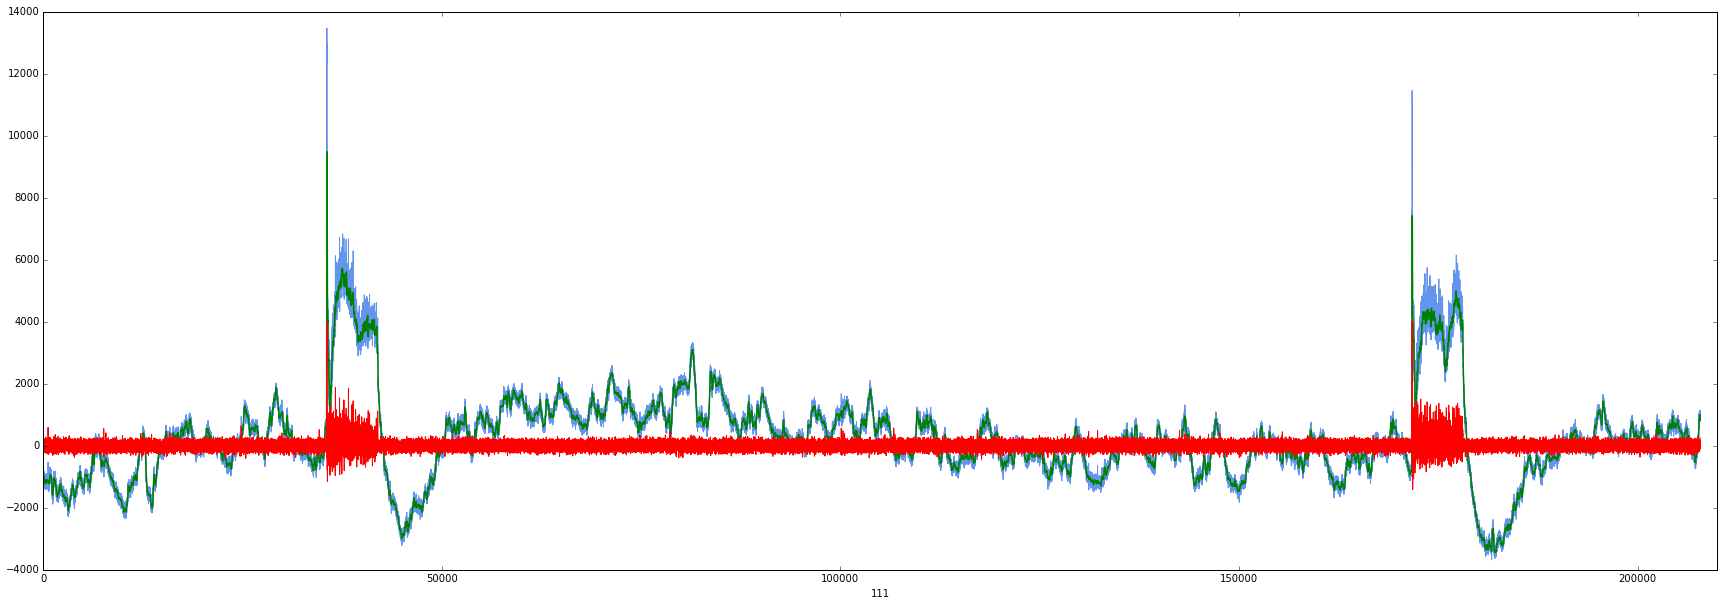

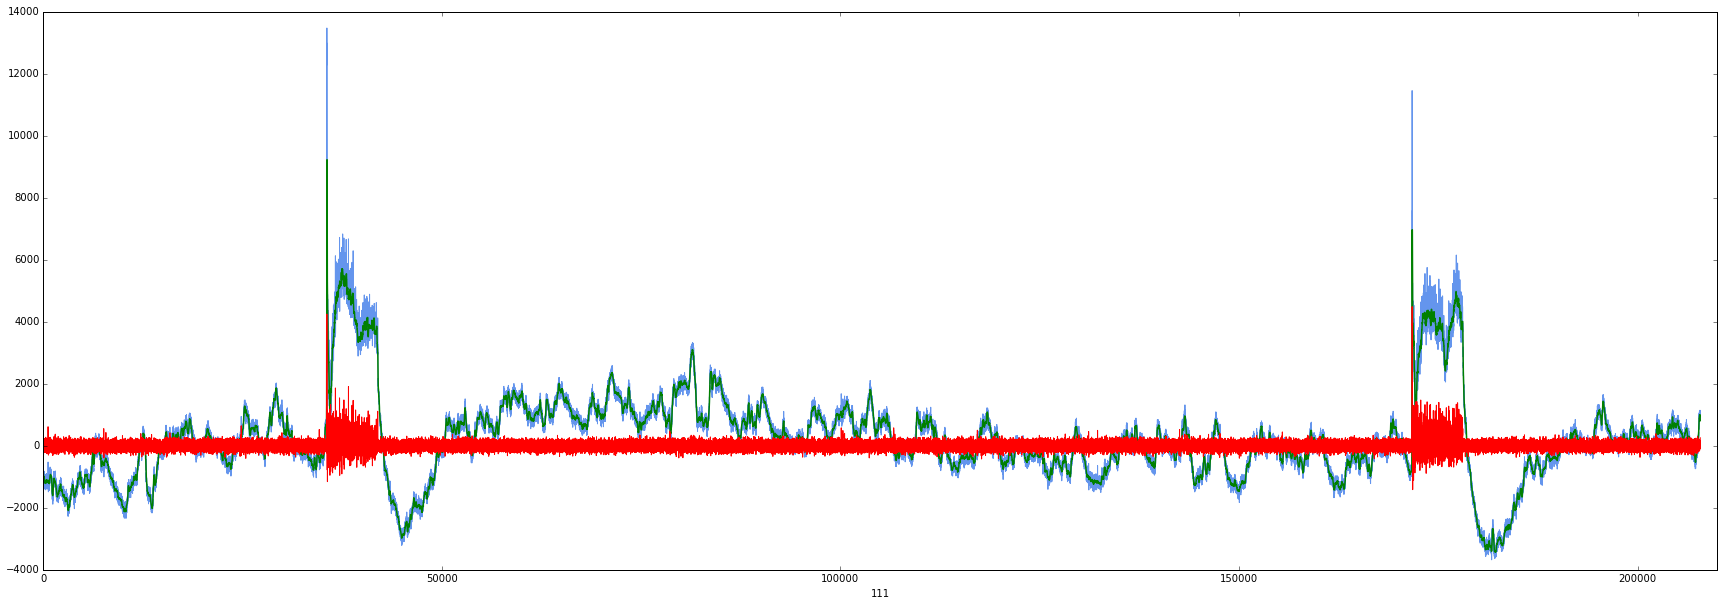

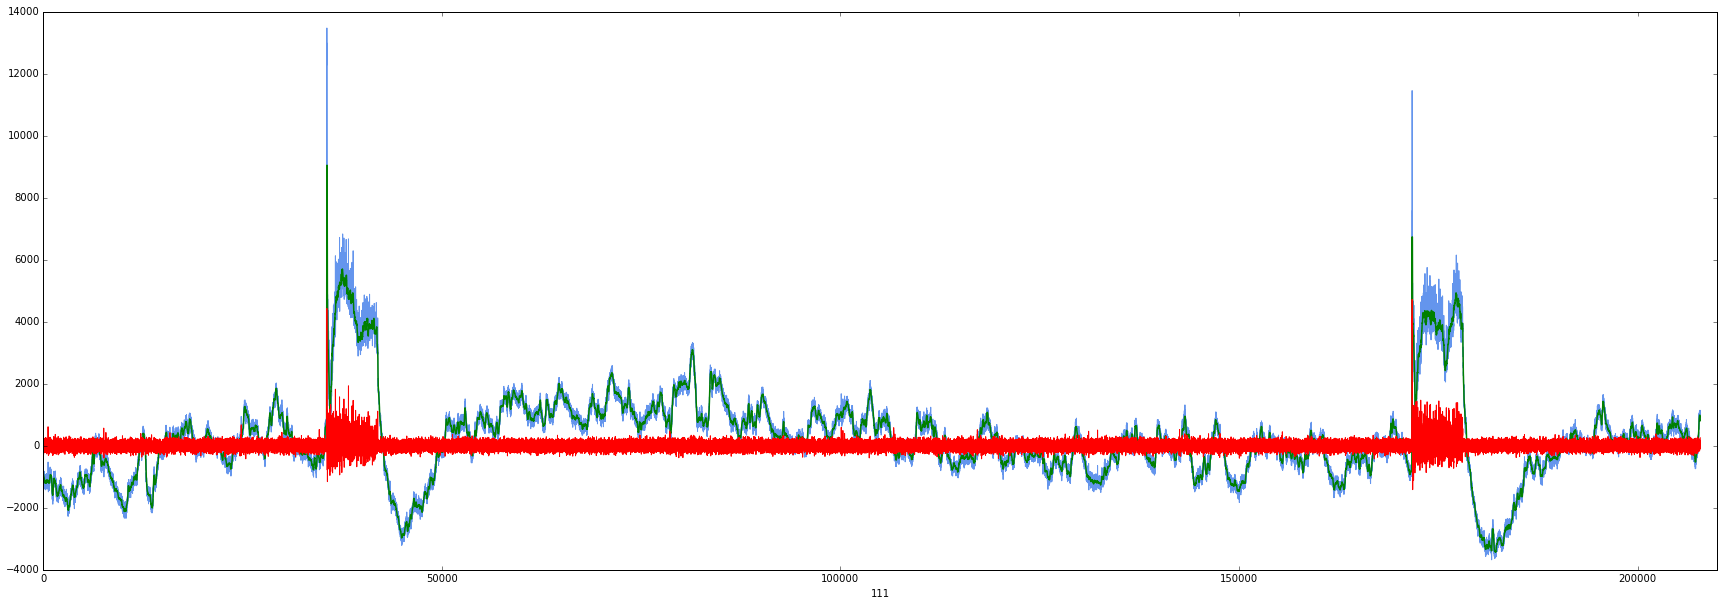

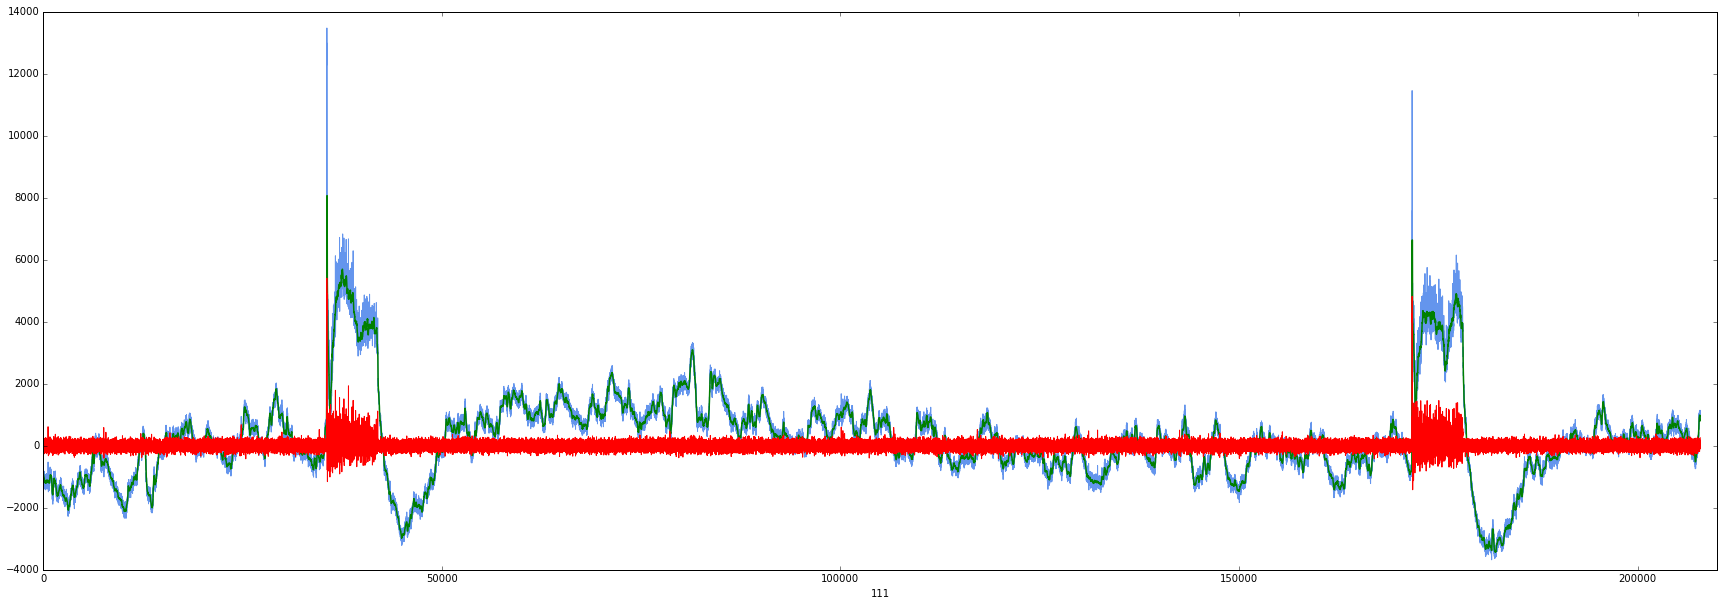

In [54]:
count = 0
for p in range(5):
    count = count + 1
    plt.figure(count, figsize=(30,10))
    plt.axis([0,210000, -4000,14000])
    plt.plot(csc, color = 'cornflowerblue')
    plt.plot(filtered[:,p], color = 'g', lw = 1.5)
    plt.plot(csc-filtered[:,p], color = 'r')

In [37]:
filtered = medfilt(csc, 91)

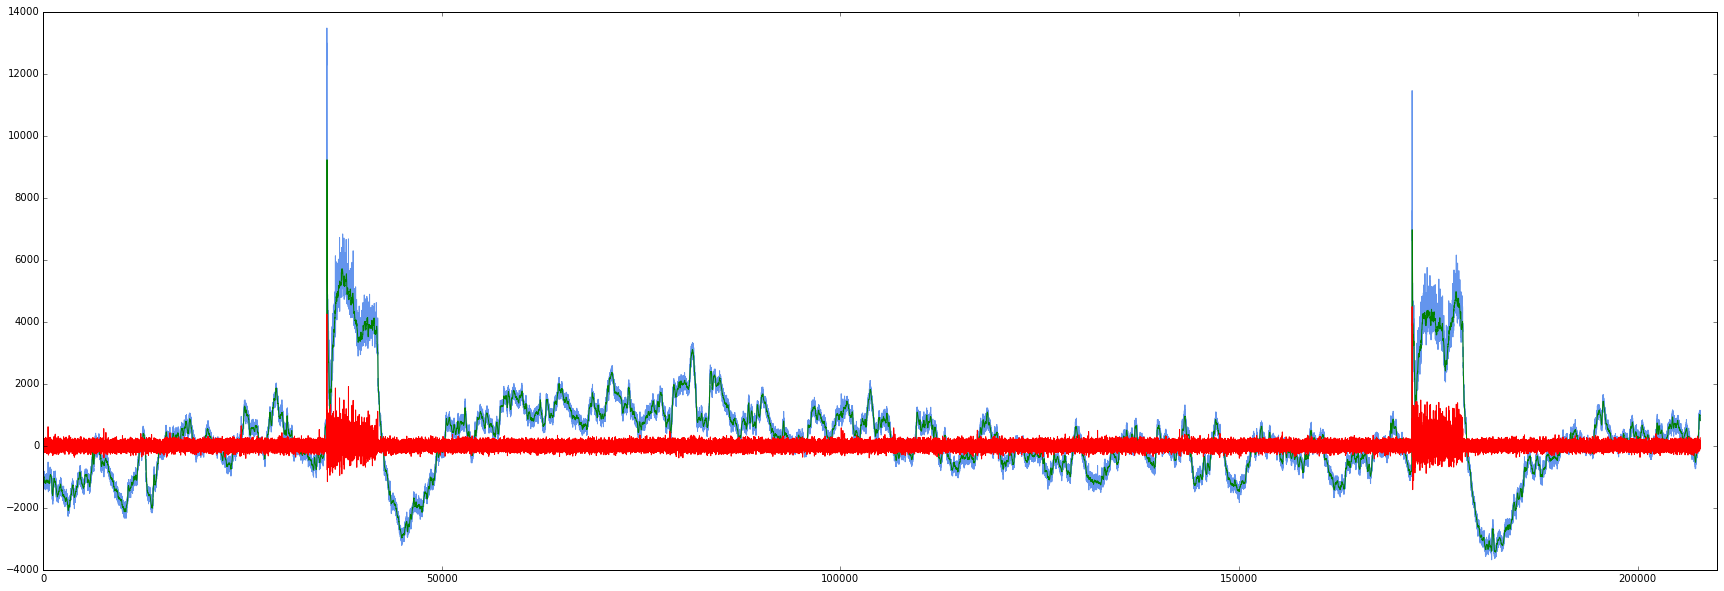

In [38]:
plt.figure(figsize=(30,10))
plt.axis([0,210000, -4000,14000])
plt.plot(csc, color ='cornflowerblue')
plt.plot(filtered, color = 'g')
plt.plot(csc-filtered, color = 'r')

In [31]:
filtered= csc - filtered

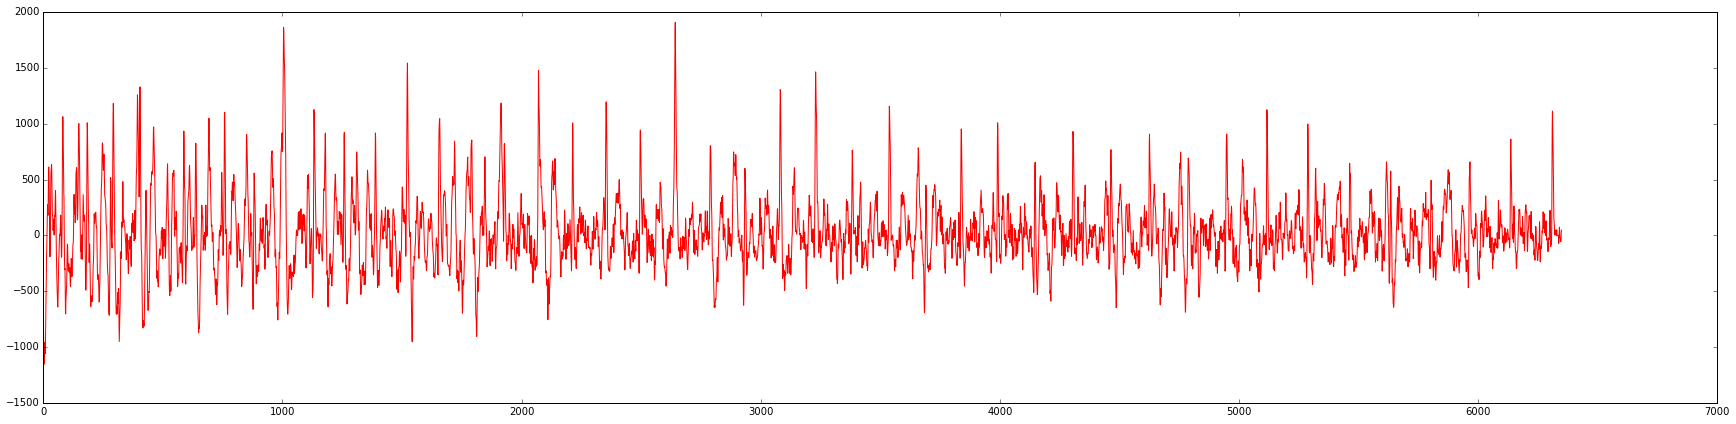

In [35]:
plt.figure(figsize=(30,7))
plt.plot(filtered[35650:42000], color = 'r')

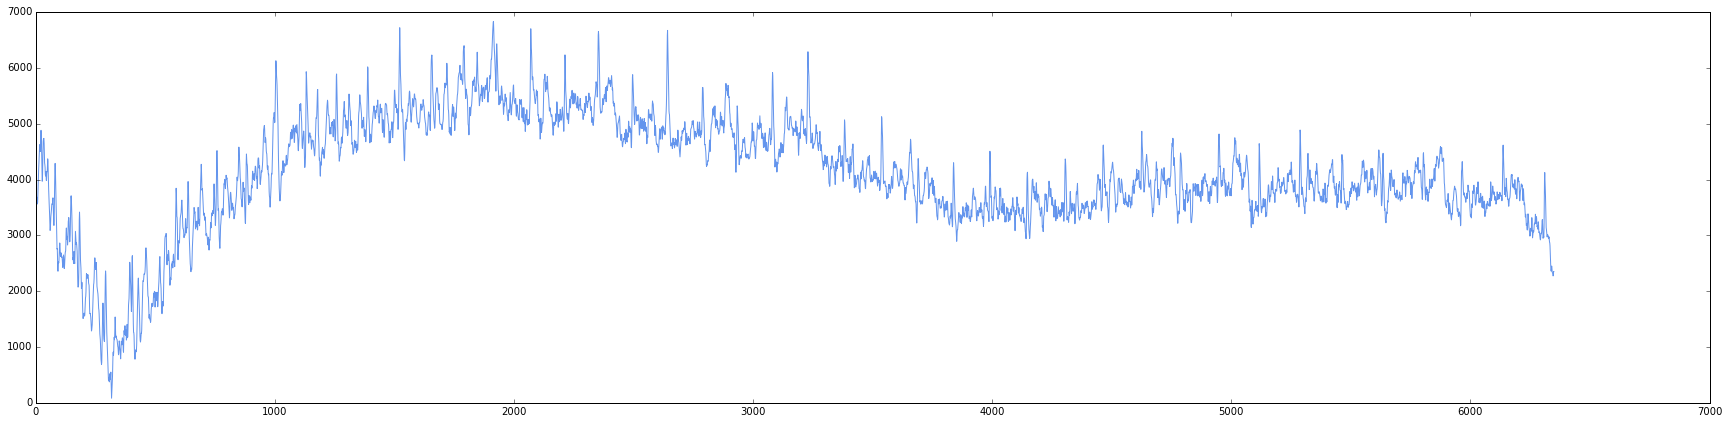

In [34]:
plt.figure(figsize=(30,7))
plt.plot(csc[35650:42000], color = 'cornflowerblue')